In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import rescale
import pandas as pd
from scipy.fft import fft, fftfreq, rfft


plt.style.use("seaborn-darkgrid")

Set up helper method to plot signal in frequency space.

In [2]:
def plot_fft(ax, y, **plot_kwargs):
    """
    Plot real-valued signal in frequency space
    
    ax: Matplotlib axis
    y: signal
    plot_kwargs: additional arguments passed on to ax.plot()
    """
    num_samples = len(y)
    
    # We are only interested in the positive side of the spectrum, which is the left half.
    num_samples_half = num_samples // 2
    
    yf = fft(y, norm="ortho")
    yf_positive = np.abs(yf[:num_samples_half])
    
    # Verify that the left half of fft is the same as rfft
    assert np.allclose(yf_positive, np.abs(rfft(y, norm="ortho"))[:-1]), "Mismatch fft and rfft"
    
    # Generate correspoding frequencies
    xf_positive = np.linspace(0.0, 1.0 / (2.0 * sample_spacing), num_samples_half, endpoint=False)
    
    # Verify that fftfreq yields the same frequencies
    assert np.allclose(xf_positive, fftfreq(num_samples, sample_spacing)[:num_samples_half])
    
    # Plot left half of frequency spectrum
    ax.plot(xf_positive, yf_positive, **plot_kwargs)

## Original samples

Generate a 1D signal from two overlapping sine waves, one with 50 Hz and one with 80 Hz.

In [3]:
def generate_samples(num_samples, sample_spacing, f1, f2):
    """
    num_samples: number of samples
    sample_spacing: spacing in between consecutive samples
    f1: frequency of first sine wave in Hz
    f2: frequency of second sine wave in hz
    """
    
    x = np.linspace(0.0, num_samples * sample_spacing, num_samples, endpoint=False)
    y = np.sin(f1 * 2.0 * np.pi * x) + 0.5 * np.sin(f2 * 2.0 * np.pi * x)
    
    return x, y

<IPython.core.display.Javascript object>


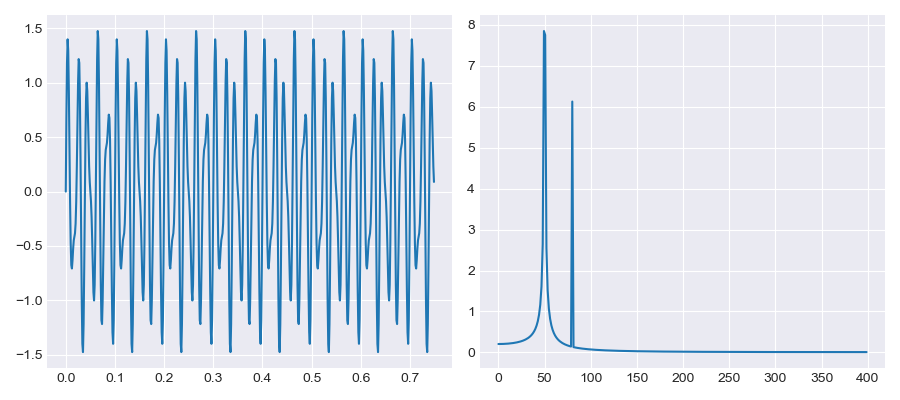

In [4]:
num_samples = 600
sample_spacing = 1./800.
f1 = 50.
f2 = 80.

# Generate samples
x, y = generate_samples(num_samples, sample_spacing, f1, f2)

# Plot signal in time and frequency domain
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
axes[0].plot(x, y)
plot_fft(ax=axes[1], y=y)
fig.tight_layout()

## Upscaling

Plot frequency spectrum after upscaling by factors `1.99`, `2.00`, and `2.01`.

Note how upscaling introduces high frequencies. These might arise as approximation errors from the bilinear interpolation.

Note that these approximation errors appear similar for scale factors `1.99` and `2.01`, but the approximation error corresponding to `2.00` diverges.

<IPython.core.display.Javascript object>


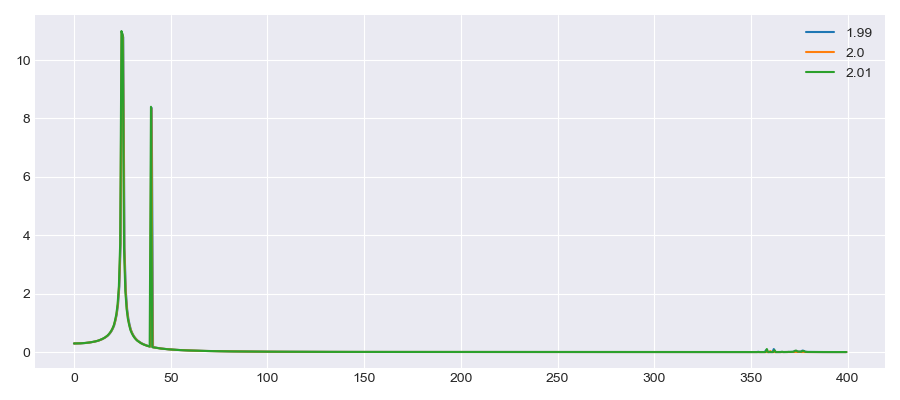

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))

# Interpolate siginal
for scale in [1.99, 2.0, 2.01]:
    num_samples_scaled = int(np.round(num_samples * scale))
    
    x_scaled = np.linspace(0.0, num_samples_scaled * sample_spacing, num_samples_scaled)
    y_scaled = rescale(y, scale, order=1, anti_aliasing=False)
    
    plot_fft(ax=ax, y=y_scaled, label=scale)
    
ax.legend(loc="upper right")

fig.tight_layout()

## Energy in upper half of frequency spectrum after upscaling

Calculate the "energy" in the upper half of frequency spectrum as a function of the upscaling factor.

Note how this energy changes gradually between neighboring scale factors. Integer scale factors diverge significantly. Also multiples of `.5` lead to smaller peaks.

<IPython.core.display.Javascript object>


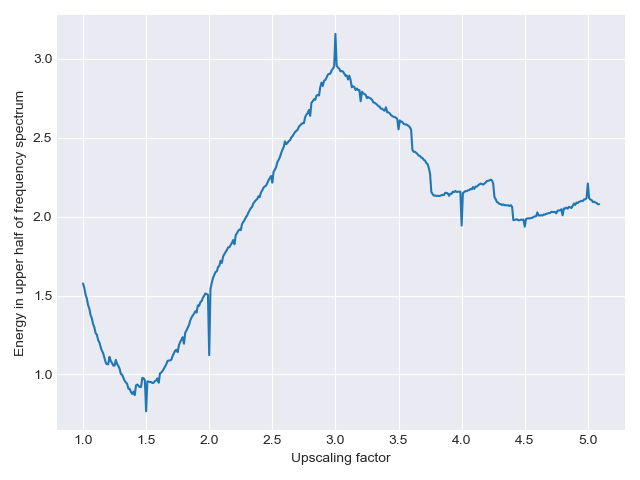

In [6]:
buffer = []

for scale in np.arange(1., 5.1, step=0.01):
    # Upscaling by factor `scale`
    y_scaled = rescale(y, scale, order=1, anti_aliasing=False)
    
    # Transform into frequency space
    # Preserve only the positive side of the spectrum
    num_samples_scaled = int(np.round(num_samples * scale))
    num_samples_scaled_half = num_samples_scaled // 2

    yf = fft(y_scaled, norm="ortho")
    yf = np.abs(yf[0:num_samples_scaled_half])
    
    # Calculate "energy" in upper half of the spectrum
    hf_energy = np.sum(yf[num_samples_scaled_half // 2:])
    
    buffer.append({
        "hf_energy": hf_energy,
        "scale": scale,
    })
    
df = pd.DataFrame(buffer)

fig, ax = plt.subplots()
ax.plot(df["scale"], df["hf_energy"])
ax.set_xlabel("Upscaling factor")
ax.set_ylabel("Energy in upper half of frequency spectrum")
fig.tight_layout()

## Correlation to resampling matrix

Formally, we can describe upscaling in matrix vector notation

\begin{equation}
    y = A x
\end{equation}

where $x$ is the original signal, $A$ is the resampling matrix, and $y$ is the upscaled signal.

For upscaling by factor 2, the resampling matrix is as follows:

\begin{equation}
A = \begin{bmatrix}
0.25 & 0.75 &      &      & \\
     & 0.75 & 0.25 &      & \\
     & 0.25 & 0.75 &      & \\
     &      & 0.75 & 0.25 & \\
     &      & 0.25 & 0.75 & \\
     &      &      & 0.75 & 0.25 \\
\end{bmatrix}
\end{equation}

For integer scale factors, it is interesting to note that there are only few unique entries in this resampling matrix.

| scale_factor | number of unique entries in resampling matrix | entries in resampling matrix |
| --- | --- | --- |
| 2.00 | 2 |                                     [-0.25, 0.25] |
| 3.00 | 3 |                            [-0.3333, 0.0, 0.3333] |
| 4.00 | 4 |                    [-0.375, -0.125, 0.125, 0.375] |
| 5.00 | 5 |                       [-0.4, -0.2, 0.0, 0.2, 0.4] |

For non-integer scale factors, the resampling matrix contains many different entries.

However, I don't know if this explains the behaviour we see with integer scale factors.